<a href="https://colab.research.google.com/github/Dahuginn/4yr_animerecommend/blob/main/%5BThesis%5DEDA_and_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

import time
import sys
sys.path.append('/content/gdrive/My Drive')
pd.options.mode.chained_assignment = None 

# Download data

The datasets were downloaded from myanimelist.net (2016)

In [3]:
anime = pd.read_csv('/content/gdrive/My Drive/anime.csv')
anime['episodes'].replace({'Unknown': 0}, inplace = True)
anime['episodes'] = anime['episodes'].astype('float')
anime.dropna(inplace=True)
print(anime.columns)
anime.head()

Index(['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members'], dtype='object')


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24.0,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.16,151266


Let's remove NSFW titles quickly so I won't get on trouble in uni!

In [4]:
#save the indices in the list
bad_h = anime.loc[anime['genre'].str.contains('hentai', case=False)]['anime_id'].values
bad_e = anime.loc[anime['genre'].str.contains('ecchi', case=False)]['anime_id'].values
bad_ya = anime.loc[anime['genre'].str.contains('yaoi', case=False)]['anime_id'].values
bad_yu = anime.loc[anime['genre'].str.contains('yuri', case=False)]['anime_id'].values
print(f'{len(bad_h) + len(bad_e) + len(bad_ya) + len(bad_yu)} titles to be deleted!')

1840 titles to be deleted!


In [5]:
anime = anime[~anime['anime_id'].isin(bad_h)][~anime['anime_id'].isin(bad_e)][~anime['anime_id'].isin(bad_ya)][~anime['anime_id'].isin(bad_yu)]
anime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10228 entries, 0 to 10895
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  10228 non-null  int64  
 1   name      10228 non-null  object 
 2   genre     10228 non-null  object 
 3   type      10228 non-null  object 
 4   episodes  10228 non-null  float64
 5   rating    10228 non-null  float64
 6   members   10228 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 639.2+ KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [6]:
rating = pd.read_csv('/content/gdrive/My Drive/rating.csv')
rating.dropna(inplace=True)
print(rating.columns)
rating.head()

Index(['user_id', 'anime_id', 'rating'], dtype='object')


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [7]:
rating = rating[~rating['anime_id'].isin(bad_h)][~rating['anime_id'].isin(bad_e)][~rating['anime_id'].isin(bad_ya)][~rating['anime_id'].isin(bad_yu)]
rating.info()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6738382 entries, 0 to 7813735
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 205.6 MB


Some statistics:

In [8]:
print(f"Number of users: {len(rating['user_id'].unique())}")
print(f"Number of animes: {len(anime['anime_id'].unique())}")
print(f"Number of animes per user: {len(rating['user_id'].unique()) / len(rating['anime_id'].unique())}")
print(f"Average number of episodes in an anime:  {anime['episodes'].mean()}")
print(f"Users' average rating: {rating.describe()['rating'].iloc[1]}")

Number of users: 73183
Number of animes: 10228
Number of animes per user: 7.737682385282301
Average number of episodes in an anime:  13.733183418068048
Users' average rating: 6.232837497191462


Merge the 2 datasets on animes' id. 

In [9]:
data = pd.merge(anime,rating,on='anime_id')
data = data.rename({'rating_y':'user_rating', 'rating_x':'rating'}, axis='columns')
data.head()

,anime_id,name,genre,type,episodes,rating,members,user_id,user_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,271,10
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,278,-1


# EDA

Let's prepare a dictionary to draw a nice barplot with genres' frequencies:

In [ ]:
def compute_freqs(column):

  # collect names of all genres in the dataset
  gen = []
  for i in data['genre'].values:
    for j in str(i).split():
      gen.append(j.strip(','))

  # genres' names that consist of more than 2 words are shortened: 
  # 'Shounen' and 'Shoujo' means shounen ai and shoujo ai, 'Slice' means slice of life
  gen = [x for x in gen if (x != 'Life' and x != 'of' and x != 'Ai')]
  uni = np.unique(gen)
  freq = []
  for i in uni:
    word_count = gen.count(i)
    freq.append((i,word_count))
  return(dict(freq))

In [ ]:
gen_freq = compute_freqs(anime['genre'])

Now we are ready to look at some graphs: rating distribution and genres' frequencies.

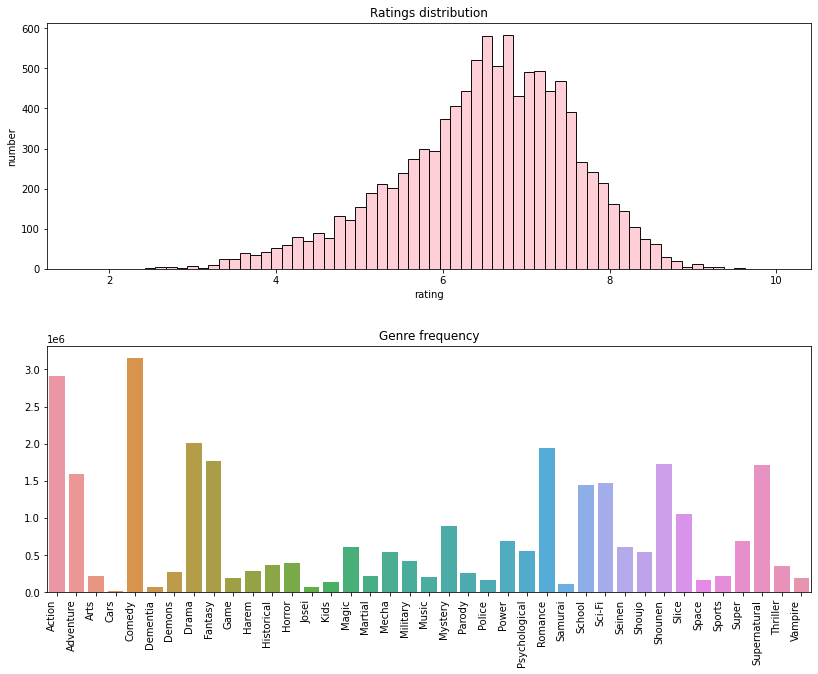

In [ ]:
fig, ax = plt.subplots(2, figsize=(12, 10))
sns.histplot(anime['rating'], color='pink', ax=ax[0])
sns.barplot(x=list(gen_freq.keys()), y = list(gen_freq.values()), ax=ax[1])

ax[0].set_title("Ratings distribution")
ax[0].set_ylabel("number")
ax[0].set_xlabel("rating")
ax[1].set_title('Genre frequency')

ax[1].set_xticklabels(list(gen_freq.keys()), rotation = 90, ha="right")
fig.tight_layout(pad=3.0)

# save the pic
# plt.savefig('/content/gdrive/My Drive/4 year/gen_info.png')
plt.show()

Why yes, my favorite anime genre is DEMENTIA, how did you know?

# Dataset for a graph

Instead of dealong with continous variable 'user_rating', let's define 'like' - assume that the user likes the anime, if rating > 5 and assign 1 to the 'rating' column, otherwise, assume that the user doesn't like the anime. 

In [10]:
rating_liked = rating.drop(rating[rating['rating'].values < 5].index).drop(columns='rating')

We need to create a specific data shape to feed it to the networkx graph creating algorithm. We need to specify the pairs of the future graph nodes - 'source' and 'target'. In this recommender system we will a homogenous graph with animes and their attributes as nodes. We can also specify the weights of the graph's edges. We will assemble the 'weight' column for all 'source'-'target' pairs from the number of users the nodes of the pair have in common.

First we'll aggregate over the newly created 'rating_liked' to assemble a list of user ids of people who liked each of the animes:

In [11]:
similar_users = rating_liked[rating_liked.duplicated('anime_id', keep=False)].groupby('anime_id')['user_id'].apply(list).reset_index()

print(similar_users.shape)
similar_users.head()

(7086, 2)


,anime_id,user_id
0,1,"[19, 21, 23, 32, 34, 43, 46, 50, 51, 55, 68, 7..."
1,5,"[19, 21, 23, 51, 139, 152, 160, 200, 234, 242,..."
2,6,"[5, 17, 32, 41, 51, 55, 81, 97, 103, 108, 109,..."
3,7,"[160, 177, 277, 352, 646, 814, 1039, 1089, 117..."
4,8,"[296, 2515, 2812, 3127, 4738, 4749, 4930, 5016..."


Later we'll use algrorithm node2vec, which uses random walks on graph to create embeddings from nodes. node2vec is a graph adaptation of word2vec - and it also works with 'sentences'. We'll create a column of attributes which will contain the information about the animes. The column 'attr' basically contains the 'sentences' that we will use later to create the nodes of our graph.

In [12]:
anime_attr = anime[['anime_id', 'name', 'type','genre']]
anime_attr['attr'] = anime_attr['name'] + ' '+ anime_attr['type'] + ' ' + anime_attr['genre']
anime_attr = anime_attr.drop(['name', 'type','genre'], axis=1)

# it seems that out of total 10228 animes users have 'liked' only 7086 animes!!
print(anime_attr.shape)
anime_attr.head()

(10228, 2)


,anime_id,attr
0,32281,"Kimi no Na wa. Movie Drama, Romance, School, S..."
1,5114,"Fullmetal Alchemist: Brotherhood TV Action, Ad..."
2,28977,"Gintama° TV Action, Comedy, Historical, Parody..."
3,9253,"Steins;Gate TV Sci-Fi, Thriller"
4,9969,"Gintama&#039; TV Action, Comedy, Historical, P..."


Now merge 'anime_attr' and 'similar_users' by anime ids:

In [13]:
anime_users = similar_users.merge(anime_attr, on=['anime_id'], how='inner')
print(anime_users.shape)
anime_users.head()

(7075, 3)


,anime_id,user_id,attr
0,1,"[19, 21, 23, 32, 34, 43, 46, 50, 51, 55, 68, 7...","Cowboy Bebop TV Action, Adventure, Comedy, Dra..."
1,5,"[19, 21, 23, 51, 139, 152, 160, 200, 234, 242,...","Cowboy Bebop: Tengoku no Tobira Movie Action, ..."
2,6,"[5, 17, 32, 41, 51, 55, 81, 97, 103, 108, 109,...","Trigun TV Action, Comedy, Sci-Fi"
3,7,"[160, 177, 277, 352, 646, 814, 1039, 1089, 117...","Witch Hunter Robin TV Action, Drama, Magic, My..."
4,8,"[296, 2515, 2812, 3127, 4738, 4749, 4930, 5016...","Beet the Vandel Buster TV Adventure, Fantasy, ..."


In [14]:
# there is a mismatch between anime_users and similar_users, 11 animes are present only in the users ratings! hmmm
set(similar_users['anime_id']) - set(anime_users['anime_id'])

{19219, 28655, 28987, 29765, 30484, 30862, 30913, 31507, 31760, 33187, 33242}

It will take too long to create a dataset needed for our graph when it has 7075 titles. It will be even harder to compute node embeddings on such a large graph. We are going to work with 800 randomly sampled animes, then:

In [ ]:
anime_users = anime_users.sample(n=800).reset_index().drop(columns=['index'])

We're getting closer to the most harrowing experience of this notebook: we will start from the first anime in the list and run all the way down comparing the first one's list in 'user_id' to the other's. The next iteration starts at the second anime, we will compare its list to the rest of 800 (we don't compare the anime with itself). In total we will make $(800-k)$ comparisons $k$ times.

In [ ]:
for_graph_weighted = {}
k = 0
start = time.time()

for i in range(1, 800):
  current_value = set(anime_users[anime_users.index == int(i-1)]['user_id'].values[0])
  for j in range(i, 800):
    compare_value = set(anime_users[anime_users.index == j]['user_id'].values[0])
    weight = len(current_value & compare_value)
    for_graph_weighted[k] = {'source': anime_users[anime_users.index == int(i-1)]['attr'].values[0], 'target': anime_users[anime_users.index == j]['attr'].values[0], 'weight': weight}
    k += 1

end = time.time()
print(end - start)

8609.669931173325


In [ ]:
graph_data = pd.DataFrame.from_dict(for_graph_weighted).T
graph_data = graph_data.drop(graph_data[graph_data['weight'] == 0].index)
graph_data['source'] = graph_data['source'].astype(str)
graph_data['target'] = graph_data['target'].astype(str)
graph_data['weight'] = graph_data['weight'].astype(int)

In [ ]:
# save the result and suffer no more
# compression_opts = dict(method='zip', archive_name='800graph.csv')
# graph_data.to_csv('/content/gdrive/My Drive/4 year/800graph.zip', index=False, compression=compression_opts)

# Creating a graph

In [15]:
graph_data = pd.read_csv('/content/gdrive/My Drive/4 year/800graph.csv')
print(graph_data.shape)
graph_data.head()

(194393, 3)


,source,target,weight
0,"Mugen no Ryvius TV Drama, Mecha, Military, Psy...","Go-Q-Choji Ikkiman TV Sci-Fi, Sports",1
1,"Mugen no Ryvius TV Drama, Mecha, Military, Psy...",Kämpfer Picture Drama Special Comedy,6
2,"Mugen no Ryvius TV Drama, Mecha, Military, Psy...","Genshiken Nidaime Specials Special Comedy, Par...",3
3,"Mugen no Ryvius TV Drama, Mecha, Military, Psy...","Ristorante Paradiso TV Drama, Josei, Romance, ...",28
4,"Mugen no Ryvius TV Drama, Mecha, Military, Psy...","Girls und Panzer TV Military, School",77


The resulting dataframe is ready for us to make it a real graph! It has 'source', 'target' and 'weight' columns that represent a connection between a pair of nodes. 

We'll use a package networkx that provides tools for working with graphs to create our first graph here:

In [16]:
graph = nx.from_pandas_edgelist(graph_data, 'source', 'target', 'weight')
nx.info(graph)

'Graph with 800 nodes and 194393 edges'

On a histogramm below (cropped it at the top to look closer though) we can see the distribution of weights among the pairs:

In [17]:
wt = nx.get_edge_attributes(graph, 'weight')

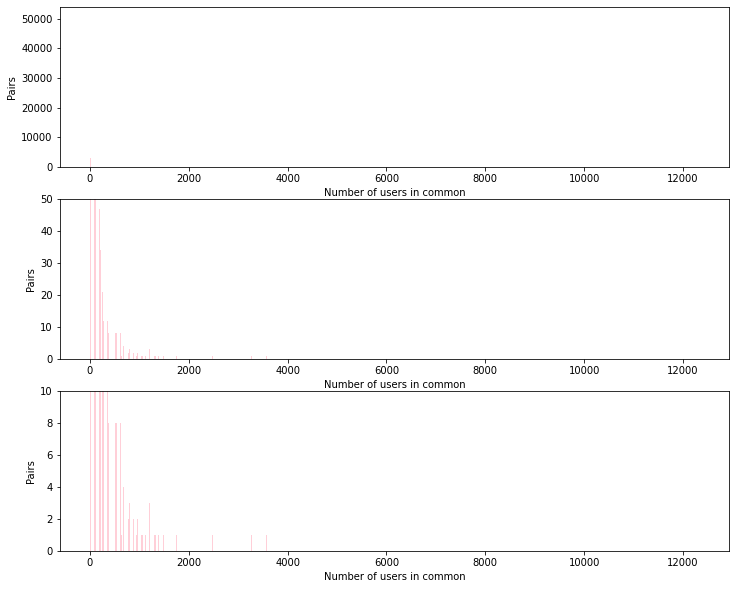

In [18]:
fig, ax = plt.subplots(3, figsize=(12, 10))

sns.histplot(wt, color='pink', ax=ax[0])

sns.histplot(wt, color='pink', ax=ax[1])
ax[1].set_ylim(bottom=-0, top=50)

sns.histplot(wt, color='pink', ax=ax[2])
ax[2].set_ylim(bottom=-0, top=10)

for i in range(0, 3):
  ax[i].set_xlabel("Number of users in common")
  ax[i].set_ylabel("Pairs")

plt.show()

In [ ]:
# save the pic
plt.savefig('/content/gdrive/My Drive/4 year/graph800_weights.png')

<Figure size 432x288 with 0 Axes>

Now we only need to make this graph a little bit less dense, otherwise it will be impossible to predict anything on it - all the possible conncetions already exist. Let's drop the pairs where the weight is less than 50. 

In [19]:
graph_data = graph_data.drop(graph_data[graph_data['weight'] <= 50].index)

There are also 11 pairs of animes with a very large number of shared viewers. We can assume that they have so many users in common not because they are super similar, but because they are very popular. We build a simple link prediction model, so these outliers with crazy weights are going to pop up in all the recomendation, regardless of what kind of a user we build a prediction for. 

You watch animes for young adults about dreams and hope, the ones that are bitter-sweet and leave you in awe at the complexity and beauty of human kind? Damn, have some Sword Art Online, mate!

In [ ]:
graph_data[graph_data['weight'] > 7000].sort_values('weight', ascending=False)

,source,target,weight
130778,"Elfen Lied TV Action, Drama, Horror, Psycholog...","Code Geass: Hangyaku no Lelouch TV Action, Mec...",12320
172554,"Toradora! TV Comedy, Romance, School, Slice of...","Code Geass: Hangyaku no Lelouch TV Action, Mec...",11189
130693,"Elfen Lied TV Action, Drama, Horror, Psycholog...","Toradora! TV Comedy, Romance, School, Slice of...",10123
38008,"Fate/Zero 2nd Season TV Action, Fantasy, Super...","Fate/Zero TV Action, Fantasy, Supernatural",10059
172539,"Toradora! TV Comedy, Romance, School, Slice of...","Bakemonogatari TV Mystery, Romance, Supernatur...",9031
181593,"Bakemonogatari TV Mystery, Romance, Supernatur...","Code Geass: Hangyaku no Lelouch TV Action, Mec...",8620
164272,"Fate/Zero TV Action, Fantasy, Supernatural","Code Geass: Hangyaku no Lelouch TV Action, Mec...",8382
72422,"Nisemonogatari TV Comedy, Mystery, Supernatural","Bakemonogatari TV Mystery, Romance, Supernatur...",8226
130763,"Elfen Lied TV Action, Drama, Horror, Psycholog...","Bakemonogatari TV Mystery, Romance, Supernatur...",7535
172716,"Toradora! TV Comedy, Romance, School, Slice of...","Boku wa Tomodachi ga Sukunai TV Comedy, Ecchi,...",7460


We'll just get rid of them, then create a new graph:

In [ ]:
graph_data = graph_data.drop(graph_data[graph_data['weight'] > 7000].index)

In [20]:
graph = nx.from_pandas_edgelist(graph_data, 'source', 'target', 'weight')
nx.info(graph)

'Graph with 399 nodes and 20771 edges'

In [21]:
nx.write_graphml(graph, "/content/gdrive/My Drive/4 year/800graph.graphml")

# Story of one anime

Let's look at our graph (a portion of a graph, as it's too large to draw). I'll rake my favorite movie 'The Memories of Marnie' and see what animes are paired with it.

We'll take 3 random 'marnie'-'other anime' pairs, then look at the 2 most tightly connected pairs these three animes form. All in all, we'll get a subgraph with 8 nodes and 7 connections:

In [ ]:
def visualize_anime(name):

  anime = graph_data[graph_data['source'] == name].sort_values('weight', ascending=False).sample(n=3)

  anime_friends = []
  for i in anime['target']:
    anime_friends.append(i)
  
  anime_datasets = []
  for i in anime_friends:
   anime_datasets.append(graph_data[graph_data['source'] == i].sort_values('weight', ascending=False).sample(n=2))
  
  anime_full = anime.append(anime_datasets[0]).append(anime_datasets[1])

  return anime_full

In [ ]:
name = 'Omoide no Marnie Movie Drama, Mystery, Psychological'
marnie = visualize_anime(name)
marnie_graph = nx.from_pandas_edgelist(marnie, 'source', 'target', 'weight')

{('Durarara!!x2 Shou TV Action, Mystery, Supernatural',
  'Aldnoah.Zero 2nd Season TV Action, Mecha, Sci-Fi, Space'): Text(-0.7104099933560868, -0.4147322696996132, '1439'),
 ('Durarara!!x2 Shou TV Action, Mystery, Supernatural',
  'Binan Koukou Chikyuu Bouei-bu LOVE! TV Comedy, Magic, School, Slice of Life'): Text(-0.7388638027086923, -0.6747561929825249, '288'),
 ('Omoide no Marnie Movie Drama, Mystery, Psychological',
  'Bakemono no Ko Movie Adventure, Supernatural'): Text(0.19354403283046423, -0.27686290507256284, '334'),
 ('Omoide no Marnie Movie Drama, Mystery, Psychological',
  'Durarara!!x2 Shou TV Action, Mystery, Supernatural'): Text(-0.28458851292087806, -0.27563366863719907, '297'),
 ('Omoide no Marnie Movie Drama, Mystery, Psychological',
  'Prison School TV Comedy, Ecchi, Romance, School, Seinen'): Text(0.2524114259686686, 0.22250099938711612, '224'),
 ('Prison School TV Comedy, Ecchi, Romance, School, Seinen',
  'High School Fleet TV Action, Military, School'): Text(0.73

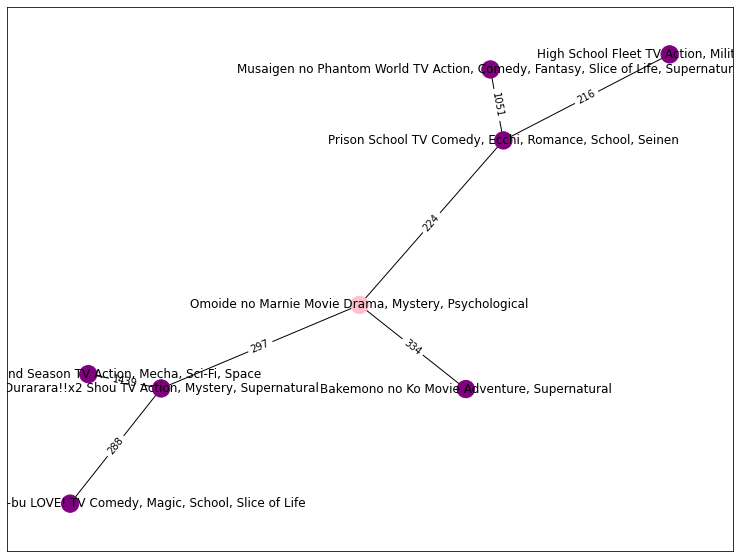

In [ ]:
color_map = []
for node in marnie_graph:
    if node == name:
        color_map.append('pink')
    else: 
        color_map.append('purple')   

plt.figure(figsize=(13, 10))
pos = nx.spring_layout(marnie_graph)
nx.draw_networkx(marnie_graph, pos, node_color=color_map)
labels = nx.get_edge_attributes(marnie_graph,'weight')
nx.draw_networkx_edge_labels(marnie_graph, pos, edge_labels=labels)

# plt.savefig('/content/gdrive/My Drive/4 year/marnie.png')